# Combine all PDF files into single file

In [1]:
# import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# !ollama list
# !ollama pull gemma3:12b
#!ollama rm gemma3:4b

In [1]:
import os

pdf_dir = '/Users/avosseler/Business Trips/2025/Barcelona' 
os.listdir(pdf_dir)

['.DS_Store',
 'Hotel_Taxi_Page1.png',
 'taxi_to_airport_barc.pdf',
 'combined_invoice.pdf',
 'flight.pdf',
 'Travel Expense Barcelona.pdf',
 'Hotel_Taxi.pdf',
 'car_sharing_first_day.pdf',
 'Travel Expense Barcelona.xlsx',
 'Image-1.jpg',
 'merged.pdf']

In [3]:
from finance_analysis.utils.utils import merge_pdfs

merge_pdfs(pdf_dir, pdf_names=["flight.pdf", "car_sharing_first_day.pdf"], output_file='merged.pdf')

Appending car_sharing_first_day.pdf...
Appending flight.pdf...
Merged PDF created as /Users/avosseler/Business Trips/2025/Barcelona/merged.pdf


In [2]:
from PyPDF2 import PdfMerger
import os

# Set the directory containing your PDFs
os.chdir(pdf_dir)

# Create a PdfMerger object
merger = PdfMerger()
#print(os.listdir(pdf_dir))

first_file = "Travel Expense Barcelona.pdf"

merger.merge(0, first_file)
print(f'Adding {first_file}...')

# Loop through all PDF files in the directory and append them
for page_number, file in enumerate(sorted(os.listdir(".")), start=1):
    if file.endswith('.pdf') and file != first_file:
        print(f'Appending {file}...')
        # merger.append(file)
        merger.merge(page_number, file)


# Write out the merged PDF
merger.write('combined_invoice.pdf')
merger.close()
print('Merged PDF created as combined PDF')

Adding Travel Expense Barcelona.pdf...
Appending Hotel_Taxi.pdf...
Appending car_sharing_first_day.pdf...
Appending combined_invoice.pdf...
Appending flight.pdf...
Appending taxi_to_airport_barc.pdf...
Merged PDF created as combined PDF


### Chat

In [ ]:
import os

file_dir = '/Users/avosseler/Business Trips/2025/Barcelona'
file_name = 'Hotel_Taxi.pdf'

with open(os.path.join(file_dir, file_name), 'rb') as f:
    image_bytes = f.read()

In [ ]:
from pdf2image import convert_from_path
import os

file_dir = '/Users/avosseler/Business Trips/2025/Barcelona'
file_name = 'Hotel_Taxi.pdf'

# Convert PDF to images
images = convert_from_path(os.path.join(file_dir, file_name))

# Save the first page as an image
image_path = os.path.join(file_dir, 'Hotel_Taxi_Page1.png')
images[0].save(image_path, 'PNG')
print(f"Saved first page as image: {image_path}")

In [ ]:
import ollama

# Read the image as bytes
with open(image_path, 'rb') as f:
    image_bytes = f.read()

prompt = "Extract all text from this image and present it in Markdown format."
prompt = "What is the name of the guest in the hotel invoice? Extract the name."

# Send the image to the Ollama model
response = ollama.chat(
    model='gemma3:12b',
    messages=[{
        'role': 'user',
        'content': prompt,
        'images': [image_bytes]
    }]
)

print(response.message.content)

### LangChain

In [ ]:
import base64
from PIL import Image
from io import BytesIO

def encode_image_to_base64(image_path):
    with Image.open(image_path) as img:
        buffered = BytesIO()
        img.save(buffered, format="PNG")  # or "PNG" if appropriate
        return base64.b64encode(buffered.getvalue()).decode("utf-8")


In [ ]:
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage

image_path = os.path.join(file_dir, 'Hotel_Taxi_Page1.png')

# Encode the image
image_b64 = encode_image_to_base64(image_path=image_path)

query = "Extract all text from this image and present it in Markdown format."
query = "What is the name of the guest in the hotel invoice?"
query = "What is the total amount in Euro on the invoice? You will find the final amount at the end of the invoice."
query = "What is the arrival date of the guest?"
query = "What is the departure date of the guest?"


content_parts = [
    {
        "type": "image_url",
        "image_url": f"data:image/png;base64,{image_b64}",
    },
    {
        "type": "text",
        "text": query
    }
]

message = HumanMessage(content=content_parts)

llm = ChatOllama(model="gemma3:12b", temperature=0.2, max_tokens=2000)

response = llm.invoke([message])
print(response.content)


## Docling OCR

In [ ]:
from finance_analysis.resources.document_processor import DocumentProcessor
import os

file_name = 'Hotel_Taxi.pdf'
#file_name = "taxi_to_airport_barc.pdf"
#file_name = "car_sharing_first_day.pdf"
#file_name = "flight.pdf"

file_path = os.path.join('/Users/avosseler/Business Trips/2025/Barcelona', file_name)

dproc = DocumentProcessor(file_path=file_path)
document = dproc.process()

In [ ]:
# document.texts
# document.tables

In [ ]:
#dproc.display_markdown()

markdown = document.export_to_markdown()

In [ ]:
from finance_analysis.resources.invoice_classifier import InvoiceDetector

clf = InvoiceDetector()

await clf.adetect(input_text=markdown)

In [ ]:
# import os
# from IPython.display import Markdown, display
# from docling.document_converter import DocumentConverter

# file_name = 'Hotel_Taxi.pdf'
# # file_name = "taxi_to_airport_barc.pdf"
# # file_name = "car_sharing_first_day.pdf"

# file_path = os.path.join('/Users/avosseler/Business Trips/2025/Barcelona', file_name)

# converter = DocumentConverter()
# result = converter.convert(file_path)
# markdown = result.document.export_to_markdown()

# display(Markdown(markdown))

In [3]:
from langchain_google_vertexai import VertexAIEmbeddings, ChatVertexAI
from finance_analysis.config import  global_config as glob

embeddings = VertexAIEmbeddings(
    model_name="text-embedding-005",
    project=glob.GCP_PROJECT
)

llm = ChatVertexAI(
    model_name="gemini-2.5-flash-preview-04-17",
    temperature=0.2,
    project=glob.GCP_PROJECT,
)

Extract infos from Taxi invoice

In [4]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field

class OutputStructure(BaseModel):
    total_amount: str = Field(..., description="The total amount in Euro on the invoice. Use the format as 1234.56")
    issue_date: str = Field(..., description="The issue date of the invoice. Use the date format as DD.MM.YYYY")

parser = JsonOutputParser(pydantic_object=OutputStructure)

taxi_prompt = PromptTemplate(
    template="""
    You are an intelligent assistant tasked with answering questions based on the provided context. 
    Use only the information in the context to answer the questions accurately. Provide the answers in JSON format.

    Context:
    {context}

    Questions:
    1. What is the total amount in Euro on the invoice? You will find the final amount at the end of the invoice.
    2. What is the date of issue?

    Please use the following output format:
    {format_instructions}
    """,
    input_variables=["context"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = taxi_prompt | llm | parser

response = chain.invoke({"context": markdown})
response

NameError: name 'markdown' is not defined

Extract Infos from Hotel Invoice

In [ ]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field

class OutputStructure(BaseModel):
    guest_name: str = Field(..., description="The name of the guest in the hotel invoice. Use the format as 'Firstname Lastname'")
    total_amount: str = Field(..., description="The total amount in Euro on the invoice. Use the format as 1234.56")
    start_date: str = Field(..., description="The arrival date of the guest. Use the date format as DD.MM.YYYY")
    end_date: str = Field(..., description="The departure date of the guest. Use the date format as DD.MM.YYYY")

parser = JsonOutputParser(pydantic_object=OutputStructure)

hotel_prompt = PromptTemplate(
    template="""
    You are an intelligent assistant tasked with answering questions based on the provided context. 
    Use only the information in the context to answer the questions accurately. Provide the answers in JSON format.

    Context:
    {context}

    Questions:
    1. What is the name of the guest in the hotel invoice?
    2. What is the total amount in Euro on the invoice? You will find the final amount at the end of the invoice.
    3. What is the arrival date of the guest?
    4. What is the departure date of the guest?

    Please use the following output format:
    {format_instructions}
    """,
    input_variables=["context"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = hotel_prompt | llm | parser

response = chain.invoke({"context": markdown})
response

In [ ]:
from finance_analysis.resources.document_processor import DocumentProcessor
import os

# file_name = 'Hotel_Taxi.pdf'
# file_name = "taxi_to_airport_barc.pdf"
# file_name = "car_sharing_first_day.pdf"
file_name = "flight.pdf"

file_path = os.path.join('/Users/avosseler/Business Trips/2025/Barcelona', file_name)

# step 1: Process the document
dproc = DocumentProcessor(file_path=file_path)
document = dproc.process()
markdown = document.export_to_markdown()

# step 2: Extract entities
from finance_analysis.resources.extractor import EntityExtractor

ent = EntityExtractor("flight")

extracted = await ent.extract_entities(markdown)
extracted

In [ ]:
extracted["total_amount"]

In [ ]:
# from langchain_text_splitters import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
# from langchain_core.documents import Document

# headers_to_split_on = [
#     ("#", "Header 1"),
#     ("##", "Header 2"),
#     ("###", "Header 3"),
# ]

# markdown_splitter = MarkdownHeaderTextSplitter(
#     headers_to_split_on=headers_to_split_on,
#     strip_headers=False
# )

# header_chunks = markdown_splitter.split_text(markdown)
# len(header_chunks)

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100
)

chunks = text_splitter.create_documents([markdown])
chunks

# from langchain_text_splitters import CharacterTextSplitter

# text_splitter = CharacterTextSplitter(
#     chunk_size=1000,
#     chunk_overlap=200
# )

# chunks = text_splitter.create_documents([markdown])


In [ ]:
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

vector_store = FAISS.from_documents(chunks, embeddings)

retriever = vector_store.as_retriever(search_kwargs={"k": 5})

prompt_template = """
Answer using only this context:
{context}

Question: {question}
"""
prompt = PromptTemplate.from_template(prompt_template)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt}
)

query = "What is the name of the guest in the hotel invoice?"
query = "What is the total amount in Euro on the invoice? You will find the final amount at the end of the invoice."
query = "What is the arrival date of the guest?"
query = "What is the departure date of the guest?"

response = qa_chain.invoke({
    "query": query
})
print(response["result"])


### Via Docling Loader

In [ ]:
from docling.chunking import HybridChunker
from langchain_docling import DoclingLoader
from langchain_docling.loader import ExportType
import os

# Your existing Docling conversion
file_dir = '/Users/avosseler/Business Trips/2025/Barcelona'
file_name = 'Hotel_Taxi.pdf'
file_path = os.path.join(file_dir, file_name)

EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"

loader = DoclingLoader(
    file_path=file_path,
    export_type=ExportType.DOC_CHUNKS,
    chunker=HybridChunker(tokenizer=EMBED_MODEL_ID),
)

docs = loader.load()

In [ ]:
docs

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

vector_store = FAISS.from_documents(docs, embeddings)

retriever = vector_store.as_retriever(search_kwargs={"k": 5})

prompt_template = """
Answer using only this context:
{context}

Question: {question}
"""

prompt = PromptTemplate.from_template(prompt_template)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt}
)

In [ ]:
query = "What is the name of the guest in the hotel invoice? Extract the name."
query = "What is the total amount due on the invoice?"

response = qa_chain.invoke({
    "query": query
})

print(response["result"])

# LangGraph 

In [3]:
from finance_analysis.resources.document_processor import DocumentProcessor
import os

file_name = 'Hotel_Taxi.pdf'
# file_name = "taxi_to_airport_barc.pdf"
# file_name = "car_sharing_first_day.pdf"
#file_name = "flight.pdf"

file_path = os.path.join('/Users/avosseler/Business Trips/2025/Barcelona', file_name)

# step 1: Process the document
dproc = DocumentProcessor(file_path=file_path)
document = dproc.process()
markdown = document.export_to_markdown()

# step 2: Extract entities
from finance_analysis.resources.extractor import EntityExtractor

ent = EntityExtractor("flight")

extracted = ent.extract_entities(markdown)
extracted

/Users/avosseler/Github_priv/financial-analyst/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
2025-05-18 21:39:34,710 - finance_analysis.resources.document_processor - INFO - Document converted successfully: /Users/avosseler/Business Trips/2025/Barcelona/Hotel_Taxi.pdf
2025-05-18 21:39:34,714 - finance_analysis.resources.get_models - INFO - Fetching google models.


input_variables=['context'] input_types={} partial_variables={'format_instructions': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"total_amount": {"description": "The total amount in Euro on the invoice. Use the format as 1234.56.", "title": "Total Amount", "type": "string"}, "issue_date": {"description": "The issue date of the invoice. Use the date format as DD.MM.YYYY", "title": "Issue Date", "type": "string"}}, "required": ["total_amount", "issue_date"]}\n```'} template='\nYou are an intelligent assistant tasked with answering questions based on the provided co

2025-05-18 21:39:35,536 - finance_analysis.resources.get_models - INFO - Models loaded successfully
I0000 00:00:1747597175.546090 54460252 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


{'total_amount': '638.85', 'issue_date': '08.05.2025'}

In [2]:
from finance_analysis.resources.invoice_classifier import InvoiceDetector

clf = InvoiceDetector()

result = await clf.adetect(input_text=markdown)
result

2025-05-18 21:38:35,295 - finance_analysis.resources.invoice_classifier - INFO - Logger created for module: finance_analysis.resources.invoice_classifier using log level: DEBUG.


{'invoice_type': 'flight',
 'class_probs': {'hotel': 0.001,
  'taxi': 0.001,
  'car_rental': 0.001,
  'restaurant': 0.001,
  'shopping': 0.05,
  'entertainment': 0.001,
  'flight': 0.9,
  'train': 0.001,
  'other': 0.044},
 'reasoning': "The text describes a bank transaction detail ('Umsatz details') rather than a typical invoice. However, the recipient is listed as 'VISA LUFTHANSA'. Lufthansa is an airline, strongly indicating that the underlying purchase for this transaction was a flight. The term 'DEKAUFUMSATZ' (purchase turnover) supports it being a purchase, and the specific recipient points to the type of purchase being a flight."}

### Singe file:

In [ ]:
import os
from typing import TypedDict, Annotated, Literal
from operator import add
from langgraph.graph import StateGraph, START, END
from finance_analysis.resources.extractor import EntityExtractor
from finance_analysis.resources.document_processor import DocumentProcessor
from finance_analysis.resources.invoice_classifier import InvoiceDetector


# 1) Define the graph state
class DocState(TypedDict):
    file_name: str
    processed_doc: str
    invoice_type: str  
    entities: Annotated[list[dict[str, str]], add]    # must be a list for concatenation


# 2) Document-processing node 
def process_document(state: DocState) -> dict[str, str]:
    print("Processing document...")    
    file_path = os.path.join('/Users/avosseler/Business Trips/2025/Barcelona', state["file_name"])

    # step 1: Process the document
    dproc = DocumentProcessor(file_path=file_path)
    document = dproc.process()
    processed = document.export_to_markdown()

    return {"processed_doc": processed}

# 3) Entity-extraction node 
async def extract_entities(state: DocState) -> dict[str, list[dict[str, str]]]:
    print("Extracting entities...")
    
    ent = EntityExtractor(state["invoice_type"])

    extracted = await ent.aextract_entities(state["processed_doc"])
    # print(extracted)
    return {"entities": [extracted]}

# 4) Invoice classification node 
async def classify_invoice(state: DocState) -> dict[str, str]:
    print("Classifying invoice...")
    clf = InvoiceDetector()

    result = await clf.adetect(input_text=state["processed_doc"])
    print(result)
    return {"invoice_type": result['invoice_type']}

# Conditional routing after processing
def should_classify(state: DocState) -> Literal["classify", "end"]:
    if len(state["processed_doc"]) > 0:
        return "classify"
    return "end"

# Conditional routing after classification
def should_extract(state: DocState) -> Literal["extract", "end"]:
    if state.get("invoice_type"):
        return "extract"
    return "end"


# 5) Build the graph
builder = StateGraph(DocState)
builder.add_node("process", process_document)
builder.add_node("classify", classify_invoice)
builder.add_node("extract", extract_entities)
builder.add_edge(START, "process")

# Set static edges (vs dynamically added edges via Command commands)

# After processing, classify if possible
builder.add_conditional_edges(
    "process",
    should_classify,
    {
        "classify": "classify",
        "end": END
    }
)

# After classification, extract entities if possible
builder.add_conditional_edges(
    "classify",
    should_extract,
    {
        "extract": "extract",
        "end": END
    }
)

# Connect extraction to end
builder.add_edge("extract", END)

# Compile graph
processor_graph = builder.compile()

In [49]:
# from IPython.display import Image, display

# display(Image(processor_graph.get_graph().draw_mermaid_png()))

In [ ]:
file_name = 'Hotel_Taxi.pdf'
file_name = "taxi_to_airport_barc.pdf"
file_name = "car_sharing_first_day.pdf"
file_name = "flight.pdf"

result = await processor_graph.ainvoke({"file_name": file_name})
result

Processing document...


2025-05-18 21:34:57,821 - finance_analysis.resources.document_processor - INFO - Document converted successfully: /Users/avosseler/Business Trips/2025/Barcelona/flight.pdf


Classifying invoice...


2025-05-18 21:35:07,879 - finance_analysis.resources.get_models - INFO - Fetching google models.


{'invoice_type': 'flight', 'class_probs': {'hotel': 0.001, 'taxi': 0.001, 'car_rental': 0.001, 'restaurant': 0.001, 'shopping': 0.05, 'entertainment': 0.001, 'flight': 0.9, 'train': 0.001, 'other': 0.044}, 'reasoning': "The text describes a bank transaction detail ('Umsatz details') rather than a typical invoice. However, the recipient is listed as 'VISA LUFTHANSA'. Lufthansa is an airline, strongly indicating that the underlying purchase for this transaction was a flight. The term 'DEKAUFUMSATZ' (purchase turnover) supports it being a purchase, and the specific recipient points to the type of purchase being a flight."}
Extracting entities...


2025-05-18 21:35:08,682 - finance_analysis.resources.get_models - INFO - Models loaded successfully


### Loop over list of names. Use dynamic routing/edges via Command

In [1]:
import os
import warnings
from typing import TypedDict, Annotated, Dict
from operator import add
import requests
from langgraph.graph import END
from langgraph.types import Command
#from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain_google_vertexai import ChatVertexAI
from finance_analysis.utils.prompts import summary_prompt
from finance_analysis.config import  global_config as glob
from finance_analysis.utils.utils import create_conversion_info

from finance_analysis.resources.extractor import EntityExtractor
from finance_analysis.resources.document_processor import DocumentProcessor
from finance_analysis.resources.invoice_classifier import InvoiceDetector
from finance_analysis.utils.data_models import CurrencyCodeLiteral
from finance_analysis.utils.utils import update_travel_expense_xlsx

warnings.filterwarnings('ignore')

directory = "Graphisoft, Budapest, Mar"
#directory = "Barcelona"
root_directory = '/Users/avosseler/Business Trips/2025'
target_dir = os.path.join(root_directory, directory)


class DocState(TypedDict):
    file_names: list[str]  # List of files to process
    current_file_index: int     # Index of the current file
    file_name: str         # Name of the current file
    processed_doc: str
    invoice_type: str
    entities: Annotated[list[dict[str, str]], add]
    inferred_types: Annotated[list[str], add]      # collect all inferred types
    currencies: Annotated[list[CurrencyCodeLiteral], add]  # collect all currencies
    descriptions: Annotated[list[str], add]       # describe each invoice, Hotel Name, etc.
    summary: str  # Summary of the processed documents
    rate_info: str  # Information about exchange rates
    
# Load the next file node
def load_next_file(state: DocState) -> Command:
    index = state.get("current_file_index", 0)
    file_list = state.get("file_names", [])
    
    # Finally: Goto Summarization if no more files
    if index >= len(file_list):
        return Command(goto="summarize")
    
    print(f"\nLoading file: {file_list[index]}")
    return Command(
        update={
            "file_name": file_list[index],
            "current_file_index": index + 1
        },
        goto="process"          # next step (-> edge)
    )

# Document-processing node 
def process_document(state: DocState) -> Command:
    print("Processing document...")    
    file_path = os.path.join(target_dir, state["file_name"])

    dproc = DocumentProcessor(file_path=file_path)
    document = dproc.process()
    processed = document.export_to_markdown()
    return Command(update={"processed_doc": processed}, goto="classify")


async def extract_and_convert(state: DocState) -> Command:
    
    # pull raw entities
    extracted = await EntityExtractor(state["invoice_type"])\
                           .aextract_entities(state["processed_doc"])
                           
    # Convert immediately
    amount = float(extracted["total_amount"])
    from_cur = extracted["currency"]
    
    print(f"Converting {amount} {from_cur} to EUR...")
    conv = convert_currency(amount, from_cur)
    print(f"Converted amount: {conv['EUR Amount']} EUR")
    
    extracted["total_amount"] = conv["EUR Amount"]
    extracted["currency"] = "EUR"
    extracted["invoice_type"] = state["invoice_type"]

    # stash both original + conversion, then loop back
    return Command(
        update={
            "entities": [extracted],
            "conversion_result": conv,
            "currencies": [from_cur],      # must be list for concatenation, as you use the 'add' operator above
            "descriptions": [extracted.get("description", "No description provided")]
        },
        goto="load"
    )

# Invoice classification node 
async def classify_invoice(state: DocState) -> Command:
    
    print("Classifying invoice...")
    clf = InvoiceDetector()
    result = await clf.adetect(input_text=state["processed_doc"])
    
    print(result['invoice_type'])
    
    return Command(
        update={
            "invoice_type": result['invoice_type'],
            "inferred_types": [result['invoice_type']]
        },
        goto="extract"
    )
    
# @tool
# def sum_calculator(numbers: list[int]) -> int:
#     """
#     A simple tool to calculate the sum of a list of numbers.

#     Args:
#         numbers (list[int]): A list of integers to sum up.

#     Returns:
#         int: The total sum of the numbers in the list.
#     """
#     if not isinstance(numbers, list):
#         raise ValueError("Input should be a list of integers.")
#     if not all(isinstance(num, int) for num in numbers):
#         raise ValueError("All elements in the list should be integers.")
#     return sum(numbers)


#@tool("convert_currency", return_direct=True)
def convert_currency(
    amount: float,
    from_currency: CurrencyCodeLiteral,
) -> Dict[str, str]:
    """
    Convert a monetary amount from one currency to another via api.frankfurter.app

    Args:
        amount (float): Input amount to convert
        from_currency (CurrencyCodeLiteral): Abbreviation of the currency to convert from, e.g. "USD"

    Returns:
        Dict[str, str]: A dictionary containing the converted amount and the date of conversion
    """
    if from_currency == "EUR":
        return {"EUR Amount": amount, "Exchange Rate - Date": "N/A"}
    
    # If currency is not Euro, convert to Euro:
    resp = requests.get(
        "https://api.frankfurter.app/latest",
        params={"amount": f"{amount}", "from": f"{from_currency.upper()}", "to": "EUR"},
        timeout=5, verify=False     # no ssl verification
    )
    resp.raise_for_status()
    euro_amount = resp.json()["rates"].get("EUR")     # Converted amount in EUR
    date = resp.json()["date"]
    print(resp.json())
    return {"EUR Amount": euro_amount, "Exchange Rate - Date": date}


async def summarize(state: DocState) -> Command:
    """
    Generates a summary of extracted entities from the given document state.

    This method logs the summarization process, ensures that entities are present in the state,
    creates exchange rate information, and uses a prompt template with a language model to
    generate a summary. The summary is then returned as part of a Command object to update the
    state and proceed to the end of the workflow.

    Args:
        state (DocState): The current document state containing extracted entities and other relevant data.

    Returns:
        Command: A command object containing the generated summary and the next workflow step.
    """

    assert "entities" in state, "No entities found in the result."

    rate_info = create_conversion_info(state)

    llm = ChatVertexAI(
        model_name="gemini-2.5-flash-preview-04-17",
        temperature=0.1,
        project=glob.GCP_PROJECT,
    )

    summary_templ = PromptTemplate(
        template=summary_prompt,
        input_variables=["context", "info_exchange_rate"],
    )

    chain = summary_templ | llm

    response = await chain.ainvoke(
        {"context": state["entities"], "info_exchange_rate": rate_info}
    )
    
    return Command(
        update={
            "summary": response.content,
            "rate_info": rate_info,
        },
        # goto=END,
        goto="update_xlsx"  # Proceed to the next step
    )
    
    
def update_xlsx_file(state: DocState) -> Command:
    """
    Placeholder for a method to edit an XLSX file based on the current state.
    This method is not implemented yet.

    Args:
        state (DocState): The current processing state.

    Returns:
        Command: A command to proceed to the next step in the workflow.
    """
    update_travel_expense_xlsx(result=state)
    print("Updating XLSX file with the extracted data...")
    return Command(goto=END)

2025-05-29 19:31:28,411 - finance_analysis.utils.utils - INFO - Logger created for module: finance_analysis.utils.utils using log level: DEBUG.
2025-05-29 19:31:28,689 - finance_analysis.resources.get_models - INFO - Logger created for module: finance_analysis.resources.get_models using log level: DEBUG.
2025-05-29 19:31:45,475 - finance_analysis.resources.document_processor - INFO - Logger created for module: finance_analysis.resources.document_processor using log level: DEBUG.
2025-05-29 19:31:45,525 - finance_analysis.resources.invoice_classifier - INFO - Logger created for module: finance_analysis.resources.invoice_classifier using log level: DEBUG.


In [ ]:
from langgraph.graph import StateGraph, START
# from langgraph.prebuilt import ToolNode

builder = StateGraph(DocState)

# tool_node = ToolNode([sum_calculator])
# builder.add_node("calculate sum", tool_node)

# # turn your function into a graph node
# builder.add_node("convert", ToolNode([convert_currency]))

builder.add_node("load", load_next_file)
builder.add_node("process", process_document)
builder.add_node("classify", classify_invoice)
builder.add_node("extract", extract_and_convert)
builder.add_node("summarize", summarize)
builder.add_node("update_xlsx", update_xlsx_file)
builder.add_edge(START, "load")

# This is only statically added here to see the edges in the visualization
# the graph will be compiled with the edges added dynamically through the use of 'Command'
# REMOVE THIS LATER: will cause recursive loop otherwise and an error!

# builder.add_edge("load", "process")
# builder.add_edge("process", "classify")
# builder.add_edge("classify", "extract")
# builder.add_edge("extract", "load")
# builder.add_edge("load", "summarize")
# builder.add_edge("summarize", "update_xlsx")
# builder.add_edge("update_xlsx", END)


# Compile the graph
processor_graph = builder.compile()

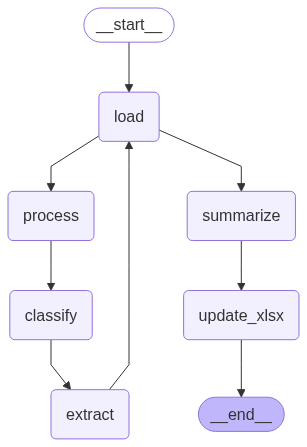

In [3]:
from IPython.display import Image, display

display(Image(processor_graph.get_graph().draw_mermaid_png()))

In [17]:
# list_of_files = [
#         "Hotel_Taxi.pdf",
#         "taxi_to_airport_barc.pdf",
#         "car_sharing_first_day.pdf",
#         "flight.pdf"
#     ]

list_of_files = [
        "Bolt to GS 2.pdf",
        # "Bolt to GS.pdf",
        "Hotel.pdf",
        # "Hotel_Taxi.pdf",
    ]

In [18]:
initial_state = {
    "file_names": list_of_files,
    "current_index": 0,
    "entities": [],
    "inferred_types": []
}

result = await processor_graph.ainvoke(initial_state)

# Add the inferred types to the entities for later use
for i,typ in enumerate(result["inferred_types"]):
    result["entities"][i]["invoice_type"] = typ


Loading file: Bolt to GS 2.pdf
Processing document...


2025-05-29 17:47:04,012 - finance_analysis.resources.document_processor - INFO - Document converted successfully: /Users/avosseler/Business Trips/2025/Graphisoft, Budapest, Mar/Bolt to GS 2.pdf
I0000 00:00:1748533624.024806 7790008 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


Classifying invoice...
taxi


I0000 00:00:1748533630.735986 7790008 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


Converting 4440.0 HUF to EUR...
{'amount': 4440.0, 'base': 'HUF', 'date': '2025-05-29', 'rates': {'EUR': 10.9811}}
Converted amount: 10.9811 EUR

Loading file: Hotel.pdf
Processing document...


2025-05-29 17:47:38,556 - finance_analysis.resources.document_processor - INFO - Document converted successfully: /Users/avosseler/Business Trips/2025/Graphisoft, Budapest, Mar/Hotel.pdf
I0000 00:00:1748533658.574411 7790008 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


Classifying invoice...
hotel


I0000 00:00:1748533666.059291 7790008 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


Converting 104072.0 HUF to EUR...
{'amount': 104072.0, 'base': 'HUF', 'date': '2025-05-29', 'rates': {'EUR': 257.39}}
Converted amount: 257.39 EUR
Using HUF as the base currency for conversion.


I0000 00:00:1748533678.141905 7790008 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


Updating XLSX file with the extracted data...


In [19]:
result

{'file_names': ['Bolt to GS 2.pdf', 'Hotel.pdf'],
 'current_file_index': 2,
 'file_name': 'Hotel.pdf',
 'processed_doc': "<!-- image -->\n\nPOINT\n\nBY  SHERATON\n\nBudapest Danube Nemetschek SE Muenchen BY 81829\n\nVosseler, Alexander\n\n## HOTEL GARAM UZEMELTETö HOTEL GARAM\n\nCTLS\n\nTERMINAL ID: HOTEL GARAM UZEMEL  TETO\n\n4**2794\n\nOTP BANK\n\nHOTEL GARAM\n\nBUDAPEST GARAM\n\nYIM\n\nVISA\n\nTERMINAL ID:\n\nws\n\n****2794\n\nELSZAMOLO/ACO:\n\nOTP BANK\n\nKARTYA/CARD:\n\nVISA\n\n**~********•9534\n\n25/03/13 09:15\n\n2222\n\n091541\n\nA0000000031010\n\nAPPROVED NOCVM\n\nAUTHCODE:\n\nAID: RESPONSE:\n\nBALE AMOUNT: EXCHANGE RATE.•\n\n104 072 HUF\n\n1.00 HUF= 0.0025968 EUR ECB MARGIN: 3 ,S?% AMOUNT IN TRANSACTION CURRENCY: 270,25 EUR I accept that I h11v~ been offered ~ choi~e of currencies fot payment and that this choice\n\nSALE\n\nfinal. I accept the conversion final amount in transaction currency. This currency conversion is provided by OTP\n\nrate l!lnd the\n\nBank Pie.\n\n6 otpba

Create Markdown summary

In [29]:
from IPython.display import Markdown, display

display(Markdown(result["summary"]))

| Type | From date | To date | Description | Amount (EUR) |
|---|---|---|---|---|
| Taxi |  |  | Taxi ride | 11.02 |
| Hotel | 11.03.2025 | 13.03.2025 | Hotel Four Points by Sheraton | 258.29 |
Daily exchange rate: 1 HUF = 0.00248 Euro (as of 29.05.25).

### Wrapped:

In [1]:
import os
from finance_analysis.resources.agent import ProcessorGraph

directory = "Graphisoft, Budapest, Mar"
# directory = "Barcelona"
root_directory = '/Users/avosseler/Business Trips/2025'
target_dir = os.path.join(root_directory, directory)
target_xlsx_file = "my_travel_expense.xlsx"

# list_of_files = [
#         "Hotel_Taxi.pdf",
#         "taxi_to_airport_barc.pdf",
#         "car_sharing_first_day.pdf",
#         "flight.pdf"
#     ]

list_of_files = [
        # "Bolt to GS 2.pdf",
        "Bolt to GS.pdf",
        "Hotel.pdf",
        # "Hotel_Taxi.pdf",
    ]

supervisor = ProcessorGraph(list_of_files=list_of_files, source_path=target_dir, target_xls_file=target_xlsx_file)

2025-05-29 17:57:20,763 - finance_analysis.resources.get_models - INFO - Logger created for module: finance_analysis.resources.get_models using log level: DEBUG.
2025-05-29 17:57:23,646 - finance_analysis.resources.document_processor - INFO - Logger created for module: finance_analysis.resources.document_processor using log level: DEBUG.
2025-05-29 17:57:23,697 - finance_analysis.resources.invoice_classifier - INFO - Logger created for module: finance_analysis.resources.invoice_classifier using log level: DEBUG.
2025-05-29 17:57:23,770 - finance_analysis.utils.utils - INFO - Logger created for module: finance_analysis.utils.utils using log level: DEBUG.
2025-05-29 17:57:23,798 - finance_analysis.resources.agent - INFO - Logger created for module: finance_analysis.resources.agent using log level: DEBUG.
2025-05-29 17:57:25,098 - finance_analysis.resources.agent - INFO - Supervisor initialized with 2 files to process.


In [2]:
result = await supervisor.ainvoke()

2025-05-29 17:57:25,110 - finance_analysis.resources.agent - INFO - Processing file: Bolt to GS.pdf



Loading file: Bolt to GS.pdf


2025-05-29 17:57:29,988 - finance_analysis.resources.document_processor - INFO - Document converted successfully: /Users/avosseler/Business Trips/2025/Graphisoft, Budapest, Mar/Bolt to GS.pdf
2025-05-29 17:57:30,005 - finance_analysis.resources.agent - INFO - Classifying invoice...
I0000 00:00:1748534261.419312 7856526 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers
2025-05-29 17:57:45,933 - finance_analysis.resources.agent - INFO - Processing file: Hotel.pdf


Converting 4440.0 HUF to EUR...
Converted amount: 10.9811 EUR

Loading file: Hotel.pdf


2025-05-29 17:57:53,319 - finance_analysis.resources.document_processor - INFO - Document converted successfully: /Users/avosseler/Business Trips/2025/Graphisoft, Budapest, Mar/Hotel.pdf
2025-05-29 17:57:53,332 - finance_analysis.resources.agent - INFO - Classifying invoice...
2025-05-29 17:58:08,445 - finance_analysis.resources.agent - INFO - Summarizing entities...


Converting 104072.0 HUF to EUR...
Converted amount: 257.39 EUR
Using HUF as the base currency for conversion.


I0000 00:00:1748534288.543242 7856526 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers
2025-05-29 17:58:15,717 - finance_analysis.resources.agent - INFO - Summary generated successfully.
2025-05-29 17:58:15,721 - finance_analysis.resources.agent - INFO - Editing XLSX file...
2025-05-29 17:58:15,723 - finance_analysis.utils.utils - INFO - Updating travel expense file: /Users/avosseler/Business Trips/2025/tmp/Travel Expense Tmp.xlsx
2025-05-29 17:58:15,802 - finance_analysis.utils.utils - INFO - Updated travel expense file saved as: /Users/avosseler/Business Trips/2025/tmp/my_travel_expense.xlsx
2025-05-29 17:58:15,802 - finance_analysis.resources.agent - INFO - XLSX file updated successfully.


In [3]:
result

{'file_names': ['Bolt to GS.pdf', 'Hotel.pdf'],
 'current_file_index': 2,
 'file_name': 'Hotel.pdf',
 'processed_doc': "<!-- image -->\n\nPOINT\n\nBY  SHERATON\n\nBudapest Danube Nemetschek SE Muenchen BY 81829\n\nVosseler, Alexander\n\n## HOTEL GARAM UZEMELTETö HOTEL GARAM\n\nCTLS\n\nTERMINAL ID: HOTEL GARAM UZEMEL  TETO\n\n4**2794\n\nOTP BANK\n\nHOTEL GARAM\n\nBUDAPEST GARAM\n\nYIM\n\nVISA\n\nTERMINAL ID:\n\nws\n\n****2794\n\nELSZAMOLO/ACO:\n\nOTP BANK\n\nKARTYA/CARD:\n\nVISA\n\n**~********•9534\n\n25/03/13 09:15\n\n2222\n\n091541\n\nA0000000031010\n\nAPPROVED NOCVM\n\nAUTHCODE:\n\nAID: RESPONSE:\n\nBALE AMOUNT: EXCHANGE RATE.•\n\n104 072 HUF\n\n1.00 HUF= 0.0025968 EUR ECB MARGIN: 3 ,S?% AMOUNT IN TRANSACTION CURRENCY: 270,25 EUR I accept that I h11v~ been offered ~ choi~e of currencies fot payment and that this choice\n\nSALE\n\nfinal. I accept the conversion final amount in transaction currency. This currency conversion is provided by OTP\n\nrate l!lnd the\n\nBank Pie.\n\n6 otpbank

In [4]:
from IPython.display import Markdown, display

display(Markdown(result["summary"]))

| Type   | From date  | To date    | Description                 | Amount (EUR) |
|--------|------------|------------|-----------------------------|--------------|
| Taxi   | 13.03.2025 |            | Taxi trip                   | 10.98        |
| Hotel  | 11.03.2025 | 13.03.2025 | Hotel Four Points by Sheraton | 257.39       |

Daily exchange rate: 1 HUF = 0.00247 Euro (as of 29.05.25).

In [12]:
result["entities"]#[0]

[{'total_amount': 11.0193,
  'currency': 'EUR',
  'issue_date': '13.03.2025',
  'description': 'Taxi service',
  'invoice_type': 'taxi'},
 {'guest_name': 'Alexander Vosseler',
  'total_amount': 258.29,
  'currency': 'EUR',
  'checkin_date': '11.03.2025',
  'checkout_date': '13.03.2025',
  'description': 'Hotel Four Points by Sheraton',
  'invoice_type': 'hotel'}]

### Update XLS file

In [ ]:
import os
from openpyxl import load_workbook
from openpyxl.workbook.properties import CalcProperties

dir_name = "/Users/avosseler/Business Trips/2025/tmp"
pfile = os.path.join(dir_name, 'Travel Expense Tmp.xlsx')

# Load your workbook (make sure data_only=False so formulas are preserved)
wb = load_workbook(pfile, data_only=False)

# Select the sheet you want to modify
ws = wb['RKA Seite 1']

# Overwrite the cells that feed into formulas
ws['C2'] = "Vosseler, Alexander"
ws['E2'] = "100392"  # cost center
ws['E3'] = "Munich"                # location
ws['C6'] = "Barcelona"             # destination
ws['C7'] = "Workshop"          # Reason for travel

rowA = 19; entries = 1; rowB = 29
for res in result["entities"]:
    if res['invoice_type'] == "hotel":
        ws[f"A{rowA}"] = res['checkin_date']
        ws[f"B{rowA}"] = entries
        ws[f"C{rowA}"] = res['description']
        ws[f"E{rowA}"] = res['total_amount']
        rowA += 1
    else:
        ws[f"A{rowB}"] = res['issue_date']
        ws[f"B{rowB}"] = entries
        ws[f"C{rowB}"] = res['description']
        ws[f"E{rowB}"] = res['total_amount']
        rowB += 1
    entries += 1
    
ws[f"C{rowB+2}"] = result["rate_info"]  # Add exchange rate info
        
# Manually attach CalcProperties to force full recalc on load
wb._calculation_properties = CalcProperties(fullCalcOnLoad=True)

# Save to a new file (or overwrite)
wb.save(os.path.join(dir_name, 'Travel Expense Tmp Edt2.xlsx'))


In [39]:
ws2 = wb['RKA Seite 2']

In [4]:
import os
from openpyxl import load_workbook
from openpyxl.workbook.properties import CalcProperties

def update_travel_expense_xlsx(
    result,
    trip_metadata={"Last/First name": "Vosseler, Alexander", 
                   "Location": "Munich", 
                   "Destination": "Barcelona", 
                   "Cost Center": "100392",
                   "Reason for travel": "Workshop"},
    dir_name="/Users/avosseler/Business Trips/2025/tmp",
    input_file="Travel Expense Tmp.xlsx",
    output_file="Travel Expense Tmp Edt.xlsx",
):
    """
    Update the travel expense Excel file with extracted invoice data.

    Args:
        result (dict): The result dictionary containing invoice entities.
        dir_name (str): Directory containing the Excel file.
        input_file (str): Name of the input Excel file.
        output_file (str): Name of the output Excel file.
        sheet_name (str): Name of the worksheet to update.
    """
    pfile = os.path.join(dir_name, input_file)
    wb = load_workbook(pfile, data_only=False)
    ws = wb["RKA Seite 1"]
    
    # --------------------------- Sheet 1 ------------------------------------
    # Overwrite the cells that feed into formulas
    ws['C2'] = trip_metadata.get("Last/First name", "Vosseler, Alexander")
    ws['E2'] = trip_metadata.get("Cost Center", "100392")  # cost center
    ws['E3'] = trip_metadata.get("Location", "Munich")  # location
    ws['C6'] = trip_metadata.get("Destination", "Barcelona")  # destination
    ws['C7'] = trip_metadata.get("Reason for travel", "Workshop")  # Reason for travel

    rowA = 19
    entries = 1
    rowB = 29
    for res in result["entities"]:
        if res['invoice_type'] == "hotel":
            ws[f"A{rowA}"] = res['checkin_date']
            ws[f"B{rowA}"] = entries
            ws[f"C{rowA}"] = res['description']
            ws[f"E{rowA}"] = res['total_amount']
            rowA += 1
        else:
            ws[f"A{rowB}"] = res['issue_date']
            ws[f"B{rowB}"] = entries
            ws[f"C{rowB}"] = res['description']
            ws[f"E{rowB}"] = res['total_amount']
            rowB += 1
        entries += 1

    ws[f"C{rowB+2}"] = result["rate_info"]  # Add exchange rate info
    
    # --------------------------- Sheet 2 ------------------------------------
    ws2 = wb['RKA Seite 2']

    # Manually attach CalcProperties to force full recalc on load
    wb._calculation_properties = CalcProperties(fullCalcOnLoad=True)

    # Save to a new file (or overwrite)
    wb.save(os.path.join(dir_name, output_file))

In [ ]:
update_travel_expense_xlsx(
    result,
    trip_metadata={
        "Last/First name": "Vosseler, Alexander",
        "Location": "Munich",
        "Destination": "Barcelona",
        "Reason for travel": "Workshop"
    },
    dir_name="/Users/avosseler/Business Trips/2025/tmp",
    input_file="Travel Expense Tmp.xlsx",
    output_file="Travel Expense Tmp Edt3.xlsx"
)